# Dynamic Bernstein–Vazirani

Here we will demonstrate correcting mid-circuit measurements using the dynamic version of the Bernstein-Vazirani algorithm.

## Frontmatter

In [1]:
import numpy as np

from qiskit import *
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2

import mthree

import matplotlib.pyplot as plt
plt.style.use('quantum-light')

Set target noisy simulator

In [2]:
backend = FakeKolkataV2()

## Circuit generation function

In [3]:
def dynamic_bv(bitstring):
    """Create a Bernstein-Vazirani circuit from a given bitstring.

    Parameters:
        bitstring (str): A bitstring.

    Returns:
        QuantumCircuit: Output circuit.
    """
    qc = QuantumCircuit(2, len(bitstring))

    # Prepare the |-x> state on target qubit
    qc.x(1)
    qc.h(1)

    # For each bit (0 or 1) build a simple circuit block
    for idx, bit in enumerate(bitstring[::-1]):

        # Initial H gate on control
        qc.h(0)
        # If bit=1, do a CNOT gate
        if int(bit):
            qc.cx(0, 1)
        # Final H gate to convert phase to computational-basis
        qc.h(0)
        # Measure
        qc.measure(0, idx)

        # If not at the final bit, recycle and reset qubits
        if idx != (len(bitstring)-1):
            # Reset control qubit for reuse
            qc.reset(0)
            # reset target qubit to minimize dephasing
            qc.reset(1)
            # Prepare the |-x> state on target qubit again
            qc.x(1)
            qc.h(1)

    return qc

## Problem setup

First we select a range of bit-string lengths to generate.  We then use this range to make all-ones bit-string circuits of those lengths.

In [4]:
bit_range = range(2, 31)

circs = [dynamic_bv('1'*N) for N in bit_range]

Next, we transpile the circuits for our target backend (simulator in this case):

In [5]:
trans_circs = transpile(circs, backend, optimization_level=3)

Next, we determine which qubits are measured to which classical bits using the `final_measurement_mapping` utility:

In [6]:
mappings = mthree.utils.final_measurement_mapping(trans_circs)
# Show a few of the mappings
mappings[:3]

[{0: 25, 1: 25}, {0: 25, 1: 25, 2: 25}, {0: 25, 1: 25, 2: 25, 3: 25}]

Lets draw the 0th circuit to verify that the mapping is indeed correct:

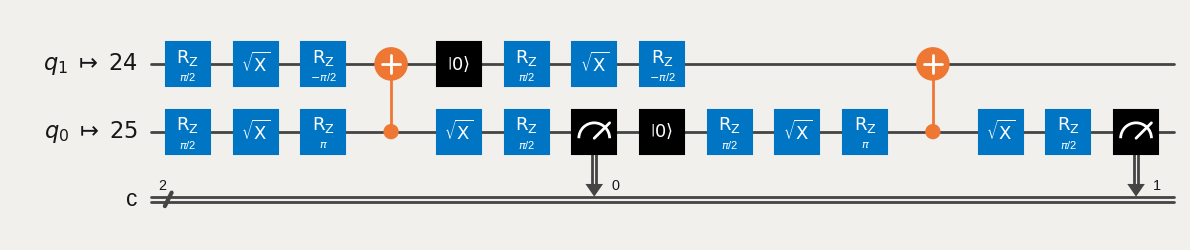

In [7]:
trans_circs[0].draw('mpl', idle_wires=False)

## Run experiment and mitigate

Here we execute the dynamic BV ciruits at 10,000 shots each.

In [8]:
shots = int(1e4)
counts = backend.run(trans_circs, shots=shots).result().get_counts()

Next we follow the usual M3 receipe to mitigate the counts.  Note that the `mappings`
have all the necessary information for correcting mid-circuit measurements.

In [9]:
mit = mthree.M3Mitigation(backend)

In [10]:
mit.cals_from_system(mappings)

In [11]:
quasis = mit.apply_correction(counts, mappings)

Because we generated all-ones bit-strings, our success criteria is the probability of being found in that state.  We can extract this probabilty from both the raw counts and the mitigated quasi-distributions

In [12]:
count_probs = [counts[idx].get('1'*num_bits)/shots \
                for idx, num_bits in enumerate(bit_range)]

quasi_probs = [quasis[idx].get('1'*num_bits) \
               for idx, num_bits in enumerate(bit_range)]

## Plot the results

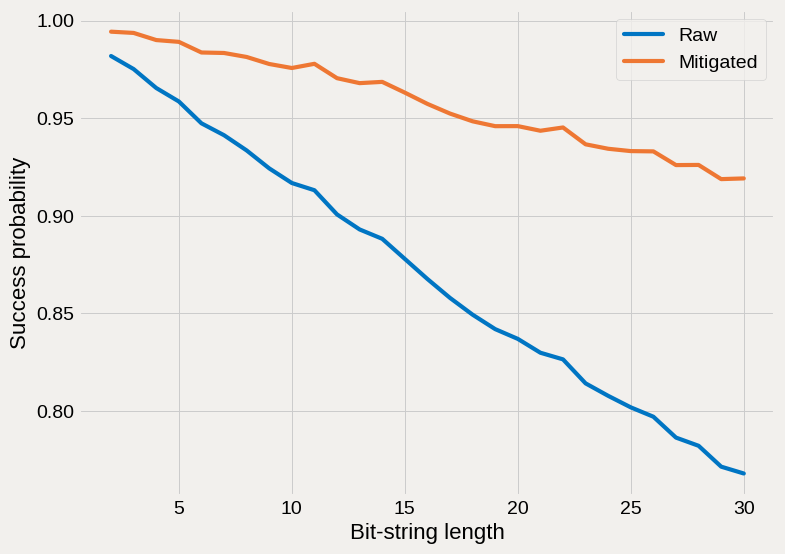

In [13]:
fig, ax = plt.subplots()
ax.plot(bit_range, count_probs, label='Raw')
ax.plot(bit_range, quasi_probs, label='Mitigated')
ax.set_ylabel('Success probability')
ax.set_xlabel('Bit-string length')
ax.legend();